In [9]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from tqdm.autonotebook import tqdm
import os
import cftime
import json
from dask import array
# import statsmodels.api as sm
from scipy.optimize import curve_fit

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'

dfs = pd.DataFrame(name.split('_')[0:3] + [name.split('_')[3].replace('.npy','')] + ['pangeo_data/'+name] for name in os.listdir('pangeo_data') if name[0] != '.')
dfs = pd.concat([dfs, pd.DataFrame(name.split('_')[0:3] + [name.split('_')[3].replace('.npy','')] + ['manual_data/'+name] for name in os.listdir('manual_data') if name[0] != '.')])
dfs = dfs.rename(columns={0:'source_id', 1:'experiment_id',2:'member_id',3:'variable_id',4:'file_name'})
dfs.to_csv('saved-data.csv')
dfs = pd.read_csv('saved-data.csv')

In [69]:
def tcr_classic(ts_expt, ts_ctrl):
    m_expt = np.mean(ts_expt[60*12:80*12])
    m_ctrl = np.mean(ts_ctrl[60*12:80*12])
    std_expt = np.std(np.random.choice(ts_expt[60*12:80*12], 10000)) / np.sqrt(240)
    std_ctrl = np.std(np.random.choice(ts_expt[60*12:80*12], 10000)) / np.sqrt(240)
    return m_expt - m_ctrl, np.sqrt(np.sum(np.square([std_expt,std_ctrl])))

In [7]:
#return dates for all datasets with real date values
def real_dates(ds):
    return [d for d in [pd.to_datetime(n, errors='coerce') for n in ds] if str(d[0]) != 'NaT']

In [54]:
def linear(x, a, b):
    return a*x + b

def ecs_gregory(ts, Ns, window=12):
    tavgs = []
    Navgs = []
    nwindows = int(len(ts)/window)
    for n in range(nwindows-2):
        tavgs += [np.mean(ts[n+1*window:(n+2)*window])]
        Navgs += [np.mean(Ns[n+1*window:(n+2)*window])]
        
    popt, pcov = curve_fit(linear, tavgs, Navgs)
    
    return popt, pcov, - popt[1] / (2 * popt[0]), [tavgs, Navgs]
    

In [42]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w    

In [3]:
def find(**keys):
    ndfs = dfs.copy()
    for k,v in keys.items():
        ndfs = ndfs[ndfs[k] == v]
    return ndfs

In [5]:
def load(ndfs=None, **keys):
    if isinstance(ndfs, type(None)):
        ndfs = find(**keys)
    ns = dict([(f, np.load(f, allow_pickle = True)) for f in ndfs.file_name])
    return ns

In [12]:
def plot_time_var(window, fmt, delta=False, avg_variants=False, data=None, **keys):
    # Get search results of right length
    ts = load(**keys).items()
    ts = np.array([t for t in ts if len(t[1][0]) > window])
    if len(ts) == 0:
        print("No data fit these keys")
        return
    
    # Keep only the transcribable dates
    dates = [d for d in [pd.to_datetime(n[1][1], errors='coerce') for n in ts] if str(d[0]) != 'NaT']
    
    # Plot each dataset in the same figure
    for f, v in sorted(ts, key=lambda x: x[0]):
        w = window
        var = moving_average(v[0] - int(delta) * np.mean(v[0,0:min(window, 12)]), w)
        d = next((d for d in dates if len(d) == len(v[0])),None)
        if not isinstance(d, type(None)):
            plt.plot_date(d[int(w/2)-1:int(len(v[0])-w/2)], var, xdate=True, fmt=fmt, label=f)

In [13]:
def ensemble_mean(expt, var):
    means = {}
    results = find(experiment_id=expt, variable_id=var).groupby('source_id')
    for source, group in results:
        data = load(group)
        xs = [d[0] for d in data.values()]
        ts = [d[1] for d in data.values()]
        mean = np.average(np.array([x for x in xs if len(x) == max([len(x) for x in xs])]),0)
        means[source] = mean
    return means

Plot a moving average for the ensemble
=======

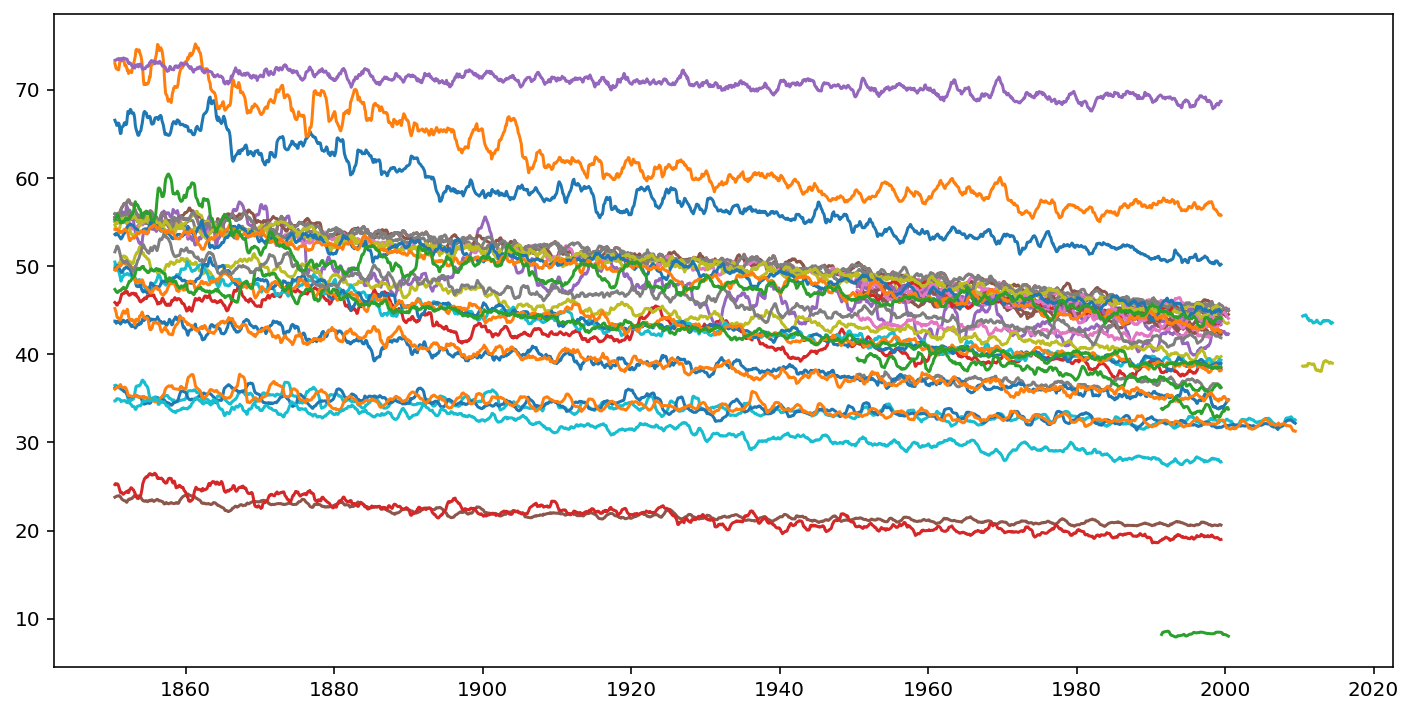

In [63]:
plt.figure('1pctCO2 runs')
plot_time_var(window=12, fmt='-', delta=False, experiment_id ='1pctCO2', variable_id='mlotst')

Get all TCRs using $\Delta T$ at $2 \times CO_2$
=========

<ErrorbarContainer object of 3 artists>

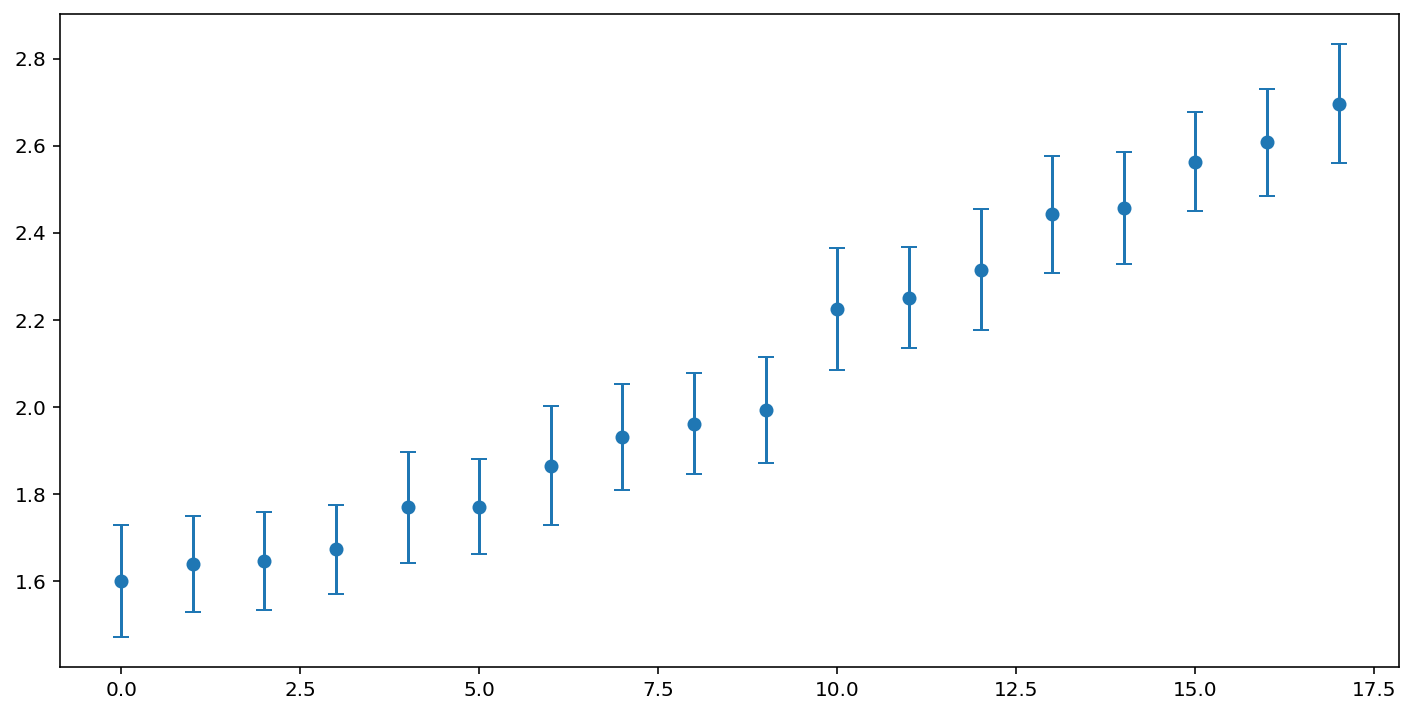

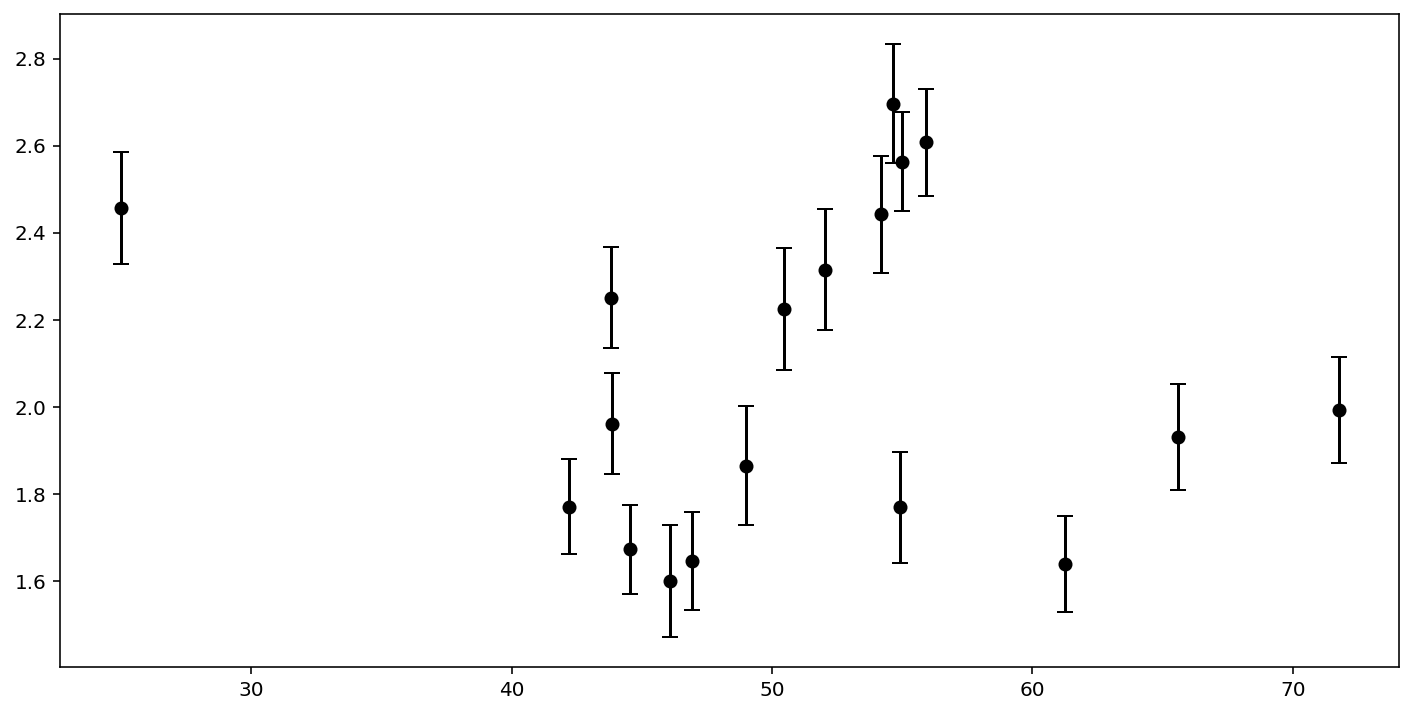

In [70]:
tcrs = []
mlds = []
names = []

ts = ensemble_mean('1pctCO2','ts')
pi_ts = ensemble_mean('piControl','ts')
pi_mlds = ensemble_mean('piControl','mlotst')
for k in ts.keys() & pi_ts.keys() & pi_mlds.keys():
    pi_t = pi_ts[k]
    t = ts[k]
    
    tcr, err = tcr_classic(t, pi_t)
    
    mld = np.mean(pi_mlds[k])
    mlds += [mld]
    tcrs += [[tcr, err]]
    names += [k]

tcrs = np.array(tcrs)
srtd = np.array(sorted(tcrs, key = lambda x: x[0]))
mlds = np.array(mlds)
plt.figure()
plt.errorbar(x=list(range(len(tcrs))), y=srtd[:,0], yerr=srtd[:,1], fmt='o', capsize=4)

plt.figure()
plt.errorbar(x=mlds, y=tcrs[:,0], yerr=tcrs[:,1], fmt='ok', capsize=4)

In [16]:
err

0.4215076284742092

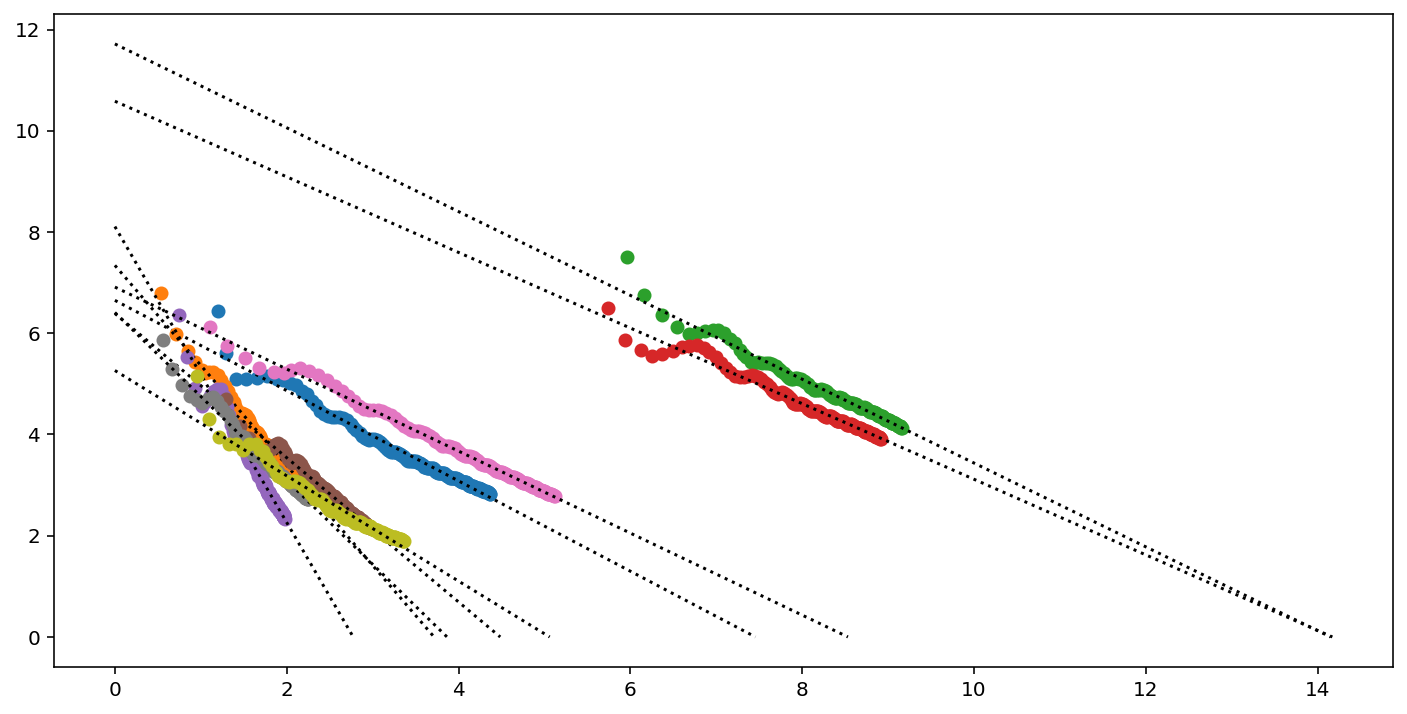

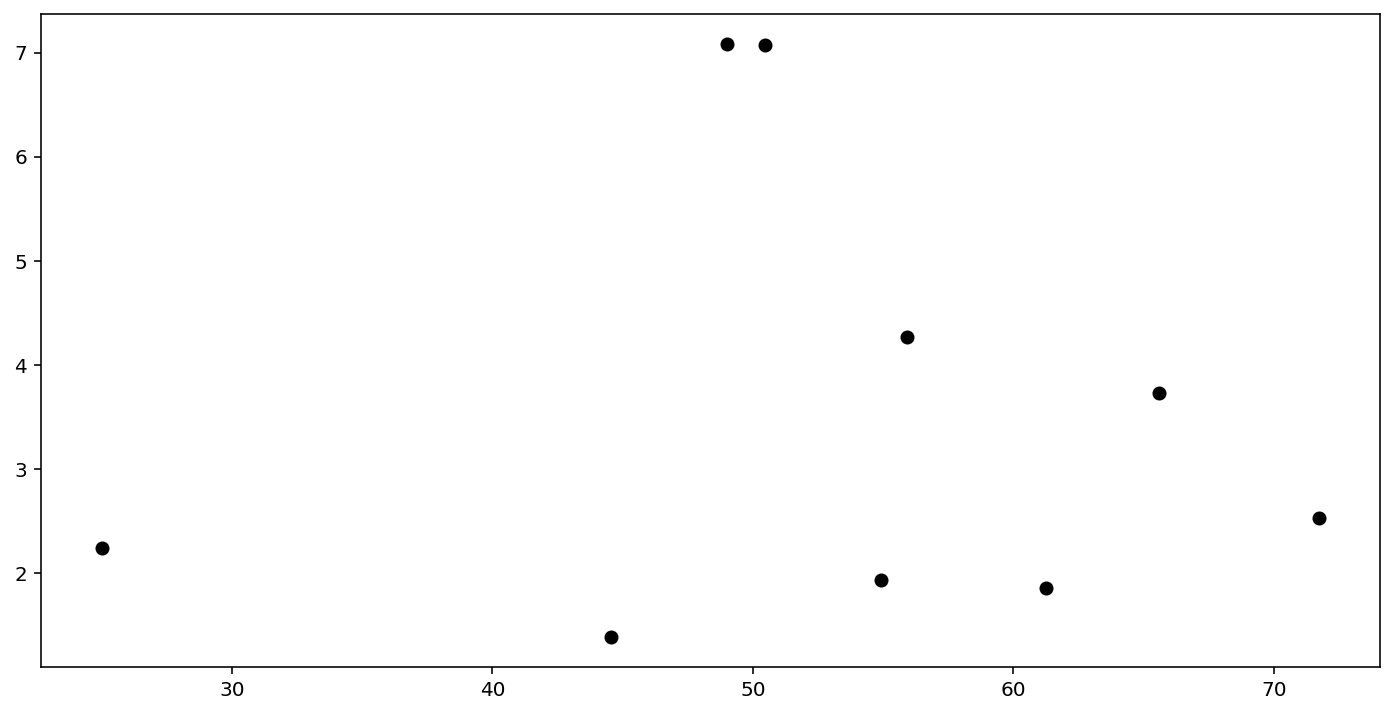

In [60]:
ecss = []
mlds = []
rtmts = []
data = []
var = 'tos'
pi_ts = ensemble_mean('piControl', var)
pi_mlds = ensemble_mean('piControl', 'mlotst')
ts = ensemble_mean('abrupt-4xCO2', var)
Rs = ensemble_mean('abrupt-4xCO2', 'rtmt')
for k in pi_ts.keys() & pi_mlds.keys() & ts.keys() & Rs.keys():
    
    t = ts[k]
    pi_t = pi_ts[k]
    R = Rs[k]
    mld = np.mean(pi_mlds[k])
    
    if len(t) < 100*12 or len(R) != len(t) or np.mean(R) < 0:
        continue
    
    minlen = min(len(t),len(pi_t))
    popt, pcov, ecs, toplot = ecs_gregory(t[0:minlen] - pi_t[0:minlen], R[0:minlen])
    
    ecss += [ecs]
    rtmts += [np.mean(R[0:60])]
    mlds += [mld]
    
    data += [[k, ecs, mld]]
    
#     plt.figure('mld')
#     plt.plot(moving_average(pi_mlds[k], 10*12))
    
    plt.plot(toplot[0], toplot[1], 'o')
    plt.plot(np.linspace(0,2*ecs), linear(np.linspace(0, 2*ecs),*popt), ':k')
    
    
df = pd.DataFrame(data)
df.to_csv('abrupt-4x_'+var+'_ranks.csv')
plt.figure()
plt.plot(mlds, ecss, 'ok')

In [68]:
ab = ensemble_mean('abrupt-4xCO2', 'mlotst')
ppy = ensemble_mean('1pctCO2', 'mlotst')
pi = ensemble_mean('piControl','mlotst')
data = []
for k in ab.keys() & ppy.keys() & pi.keys():
    data += [[k, np.mean(pi[k]), np.mean(ppy[k]), np.mean(ab[k])]]
pd.DataFrame(data).to_csv('mlotst-compare.csv')

In [38]:
toplot[0]

[3.0415559816595, 2.044476674269471, 1.9162744630335107, 1.6802716770209372]

In [7]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
gcs = gcsfs.GCSFileSystem(token='anon')

In [8]:
for r in redownload:
    check = df[(df.source_id == r[0]) & (df.experiment_id == r[1]) & (df.variable_id == r[2])]
    print(check)

Empty DataFrame
Columns: [activity_id, institution_id, source_id, experiment_id, member_id, table_id, variable_id, grid_label, zstore, dcpp_init_year]
Index: []
Empty DataFrame
Columns: [activity_id, institution_id, source_id, experiment_id, member_id, table_id, variable_id, grid_label, zstore, dcpp_init_year]
Index: []
Empty DataFrame
Columns: [activity_id, institution_id, source_id, experiment_id, member_id, table_id, variable_id, grid_label, zstore, dcpp_init_year]
Index: []
Empty DataFrame
Columns: [activity_id, institution_id, source_id, experiment_id, member_id, table_id, variable_id, grid_label, zstore, dcpp_init_year]
Index: []
Empty DataFrame
Columns: [activity_id, institution_id, source_id, experiment_id, member_id, table_id, variable_id, grid_label, zstore, dcpp_init_year]
Index: []
Empty DataFrame
Columns: [activity_id, institution_id, source_id, experiment_id, member_id, table_id, variable_id, grid_label, zstore, dcpp_init_year]
Index: []
Empty DataFrame
Columns: [activity